In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import gc


# xsuite
import xtrack as xt
import xmask as xm
import xfields as xf
import xpart as xp
import xobjects as xo


# BBStudies
import sys
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies')
sys.path.append('/home/phbelang/abp/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as tune
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Base as phys
import BBStudies.Physics.Constants as cst







tracked      = xPlus.Tracking_Interface.from_parquet('zfruits/tracking',partition_name='BUNCH',partition_ID='0224')
# tracked2     = xPlus.Tracking_Interface.from_parquet('zfruits/tracking',partition_name='BUNCH',partition_ID='0001')
calculations = xPlus.Tracking_Interface.from_parquet('zfruits/calculations',partition_name='BUNCH',partition_ID='0224')


In [11]:
calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.y_max)).sort_values(ascending=False).index

Index([  0,  44,  58,  79,  78,  89, 106,   6, 109, 108,
       ...
        68,  84,  95,  97, 104,  96, 105, 107,  88,  98],
      dtype='int64', name='particle', length=110)

In [10]:
tracked.df.groupby('particle').get_group(44)

,BUNCH,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
44000,224,0,44,0.000735,-0.000009,0.000577,0.000017,0.000011,0.000001,1,0
44001,224,1,44,0.000417,-0.000015,0.001803,0.000016,0.000013,0.000001,1,0
44002,224,2,44,-0.000929,0.000017,-0.001766,-0.000026,-0.000011,0.000001,1,0
44003,224,3,44,0.000216,0.000003,-0.000162,0.000008,0.000005,0.000001,1,0
44004,224,4,44,0.000889,-0.000021,0.002007,0.000021,0.000024,0.000001,1,0
...,...,...,...,...,...,...,...,...,...,...,...
44197,224,197,44,-0.005672,0.000136,-0.007916,-0.000121,0.001429,0.000002,1,0
44198,224,198,44,0.005977,-0.000080,0.001299,0.000055,0.001652,0.000002,1,0
44199,224,199,44,-0.002884,-0.000014,0.007047,0.000056,0.001589,0.000002,1,0
44200,224,200,44,0.001066,0.000081,-0.008979,-0.000148,0.001624,0.000002,1,0


In [25]:
list(calc.stop_at_turn)

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1000]

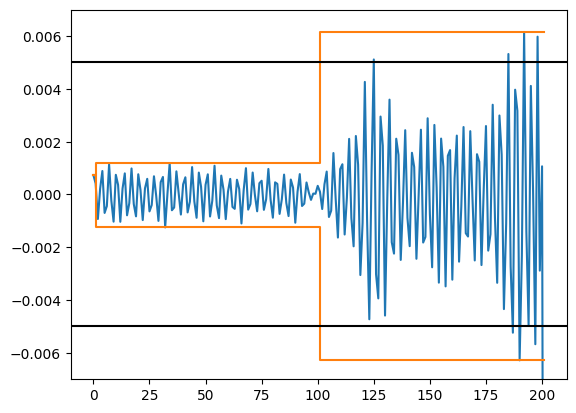

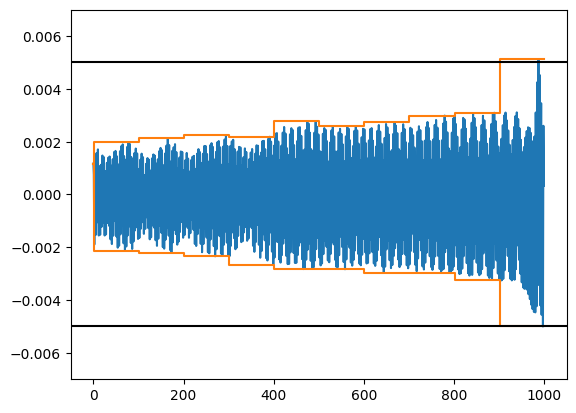

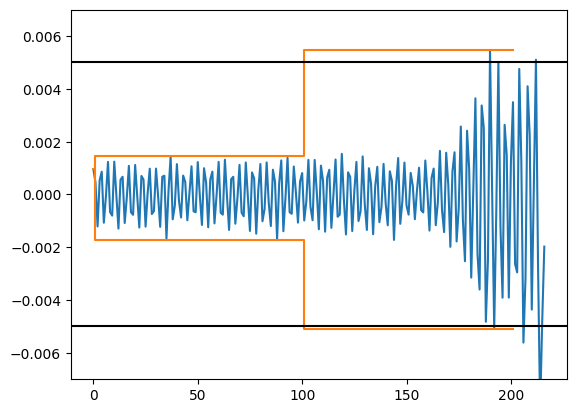

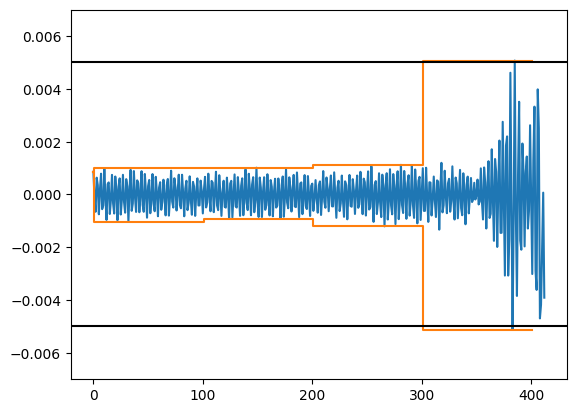

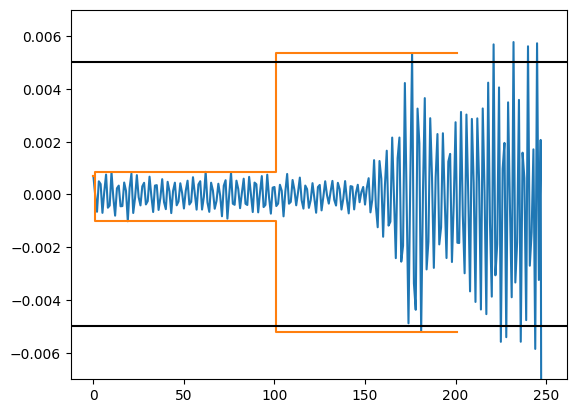

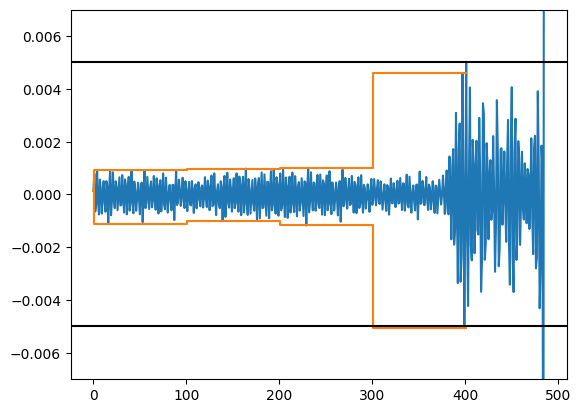

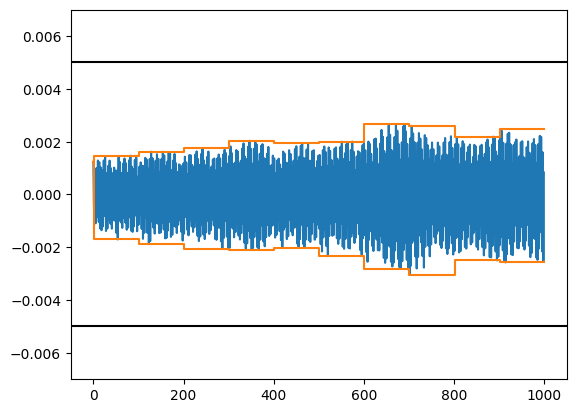

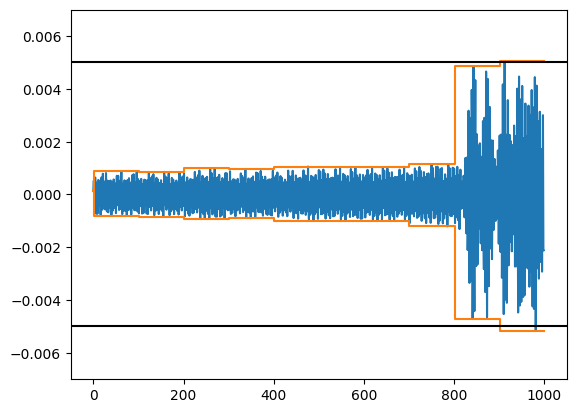

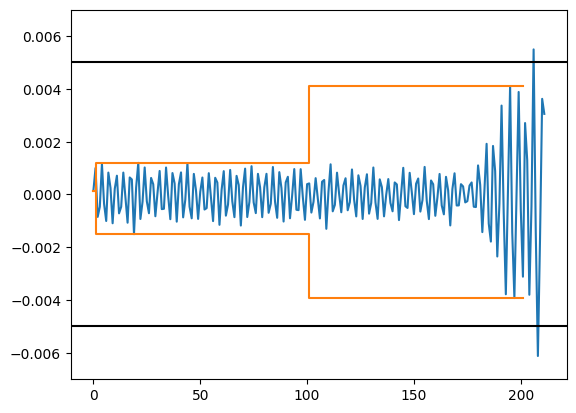

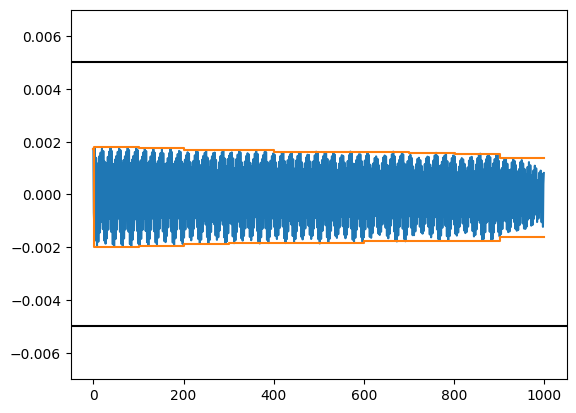

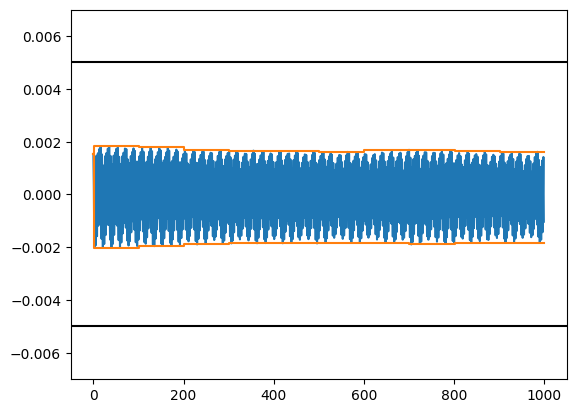

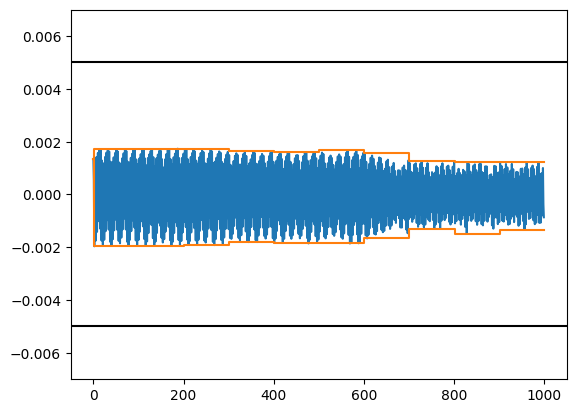

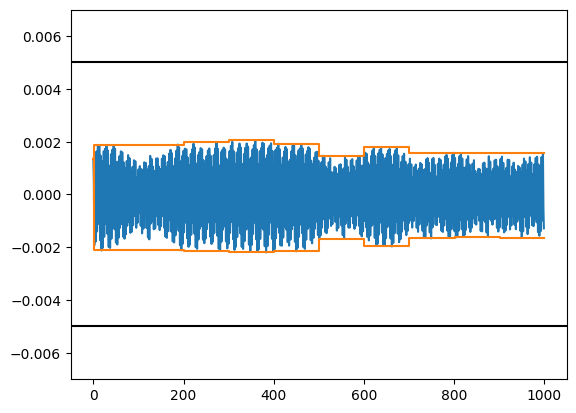

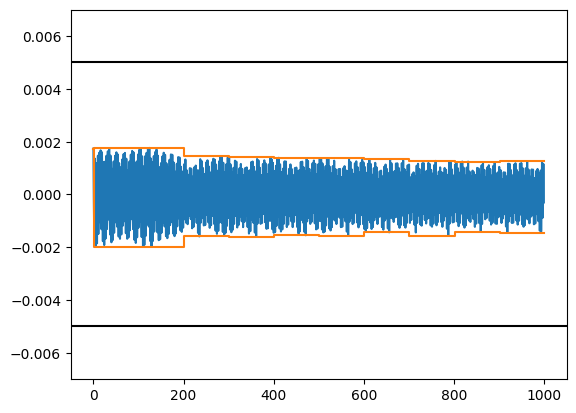

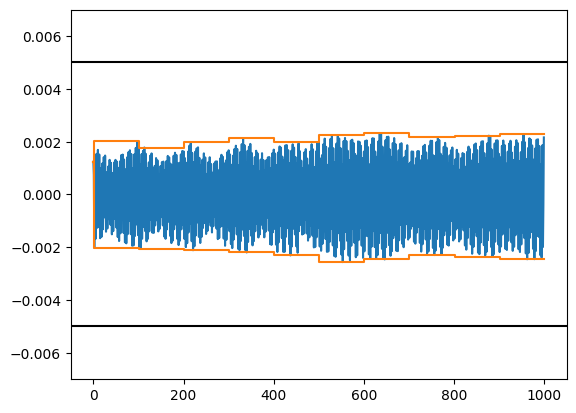

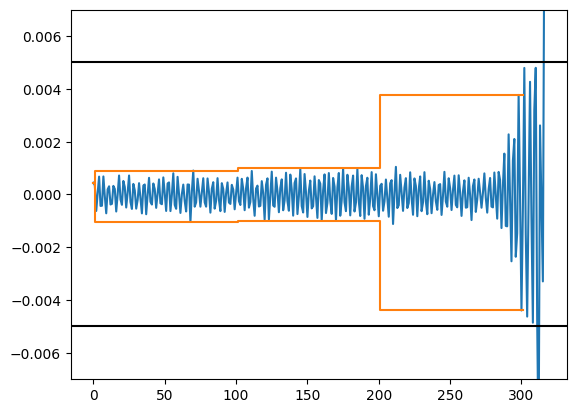

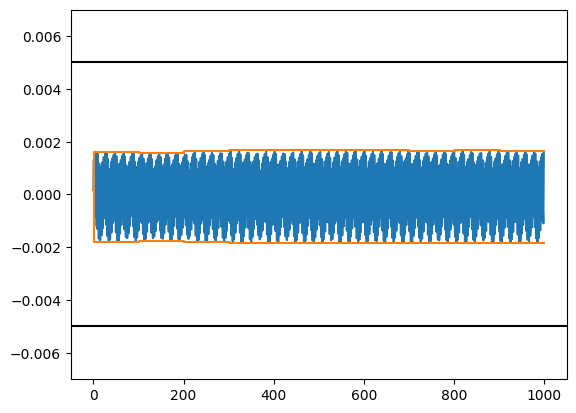

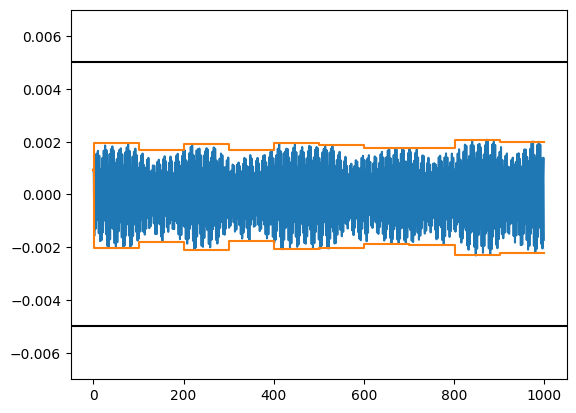

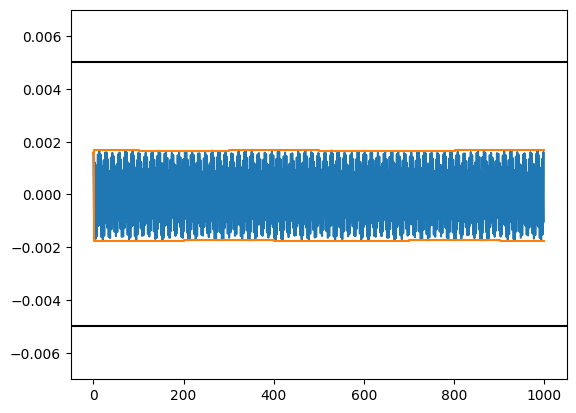

In [29]:

# for (name,df),(name2,calc) in zip(tracked.df.groupby('particle'),calculations.calculations.groupby('particle')):
    # assert name==name2, "Problem with the particle ID"
    # if name in [10,20,30]:

worst_particles = calculations.calculations.groupby('particle').apply(lambda part: np.max(part.x_max)-np.min(part.y_max)).sort_values(ascending=False).index
for part_ID in worst_particles[1:20]:#np.arange(10,20):
    df = tracked.df.groupby('particle').get_group(part_ID)
    calc = calculations.calculations.groupby('particle').get_group(part_ID)

    plt.figure()
    plt.plot(df.turn,df.x,'-')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_min) + [np.nan],'-',where='post')
    plt.step(list(calc.start_at_turn) + [list(calc.stop_at_turn)[-1]],list(calc.x_max) + [np.nan],'-',where='post',color='C1')
    plt.axhline(0.005,color='k')
    plt.axhline(-0.005,color='k')
    # else:
    #     continue
    plt.ylim([-0.007,0.007])

In [19]:
calc.start_at_turn,calc.stop_at_turn

(18        0
 128       1
 238     101
 348     201
 458     301
 568     401
 678     501
 788     601
 898     701
 1008    801
 1118    901
 Name: start_at_turn, dtype: int64,
 18         1
 128      101
 238      201
 348      301
 458      401
 568      501
 678      601
 788      701
 898      801
 1008     901
 1118    1000
 Name: stop_at_turn, dtype: int64)

In [33]:
tracked.df[tracked.df.state == 1].groupby('turn').count()

,BUNCH,particle,x,px,y,py,zeta,pzeta,state,at_element
turn,,,,,,,,,,
0,110,110,110,110,110,110,110,110,110,110
1,110,110,110,110,110,110,110,110,110,110
2,110,110,110,110,110,110,110,110,110,110
3,110,110,110,110,110,110,110,110,110,110
4,110,110,110,110,110,110,110,110,110,110
...,...,...,...,...,...,...,...,...,...,...
995,104,104,104,104,104,104,104,104,104,104
996,104,104,104,104,104,104,104,104,104,104
997,104,104,104,104,104,104,104,104,104,104


In [26]:
tracked.df[tracked.df['turn']>=901]

,BUNCH,turn,particle,x,px,y,py,zeta,pzeta,state,at_element
901,224,901,0,0.000143,-6.805550e-06,-0.000362,-3.099053e-06,-0.000005,0.000001,1,0
902,224,902,0,-0.000513,1.031996e-05,0.000359,5.388709e-06,-0.000018,0.000001,1,0
903,224,903,0,0.000207,-2.949726e-07,0.000089,-9.283838e-07,-0.000008,0.000001,1,0
904,224,904,0,0.000344,-9.603251e-06,-0.000416,-4.448197e-06,-0.000002,0.000001,1,0
905,224,905,0,-0.000447,7.055195e-06,0.000239,4.446146e-06,-0.000016,0.000001,1,0
...,...,...,...,...,...,...,...,...,...,...,...
107609,224,995,109,-0.000348,7.980407e-06,-0.002026,-2.006580e-05,-0.000068,0.000001,1,0
107610,224,996,109,0.000269,-3.210367e-06,0.001621,2.584256e-05,-0.000058,0.000001,1,0
107611,224,997,109,0.000200,-6.525315e-06,0.000543,-3.805127e-06,-0.000057,0.000001,1,0
107612,224,998,109,-0.000381,6.900698e-06,-0.002145,-2.246242e-05,-0.000067,0.000001,1,0


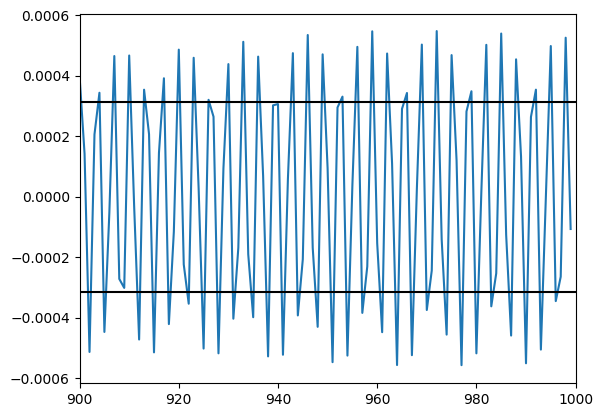

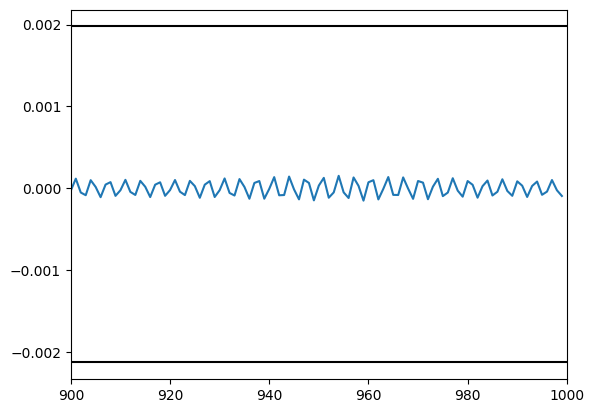

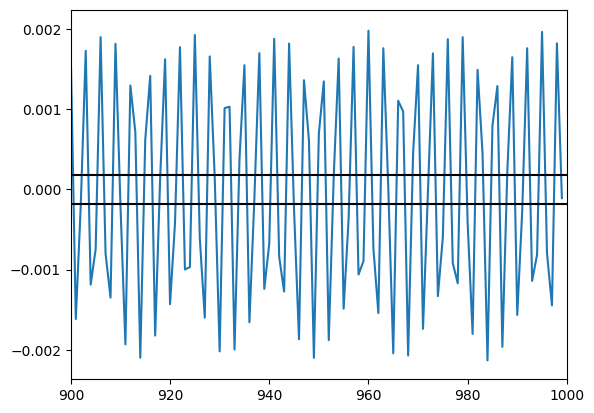

In [24]:
import matplotlib.pyplot as plt
test = calculations._calculations
for part in [0,10,20]:
    plt.figure()
    plt.plot(tracked.df.groupby('particle').get_group(part).turn,tracked.df.groupby('particle').get_group(part).x,'-')
    plt.axhline(test.groupby('start_at_turn').get_group(901).iloc[part].x_min,color='k')
    plt.axhline(test.groupby('start_at_turn').get_group(901).iloc[part].x_max,color='k')
    plt.xlim(900,1000)